In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize']=20,8
plt.style.use('ggplot')

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Statsmodel imports
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('/content/Alcohol_Sales.csv', index_col='DATE', parse_dates=True)
df.index.freq='MS'
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [3]:
df.rename({'S4248SM144NCEN':'Sales'}, axis=1, inplace=True)

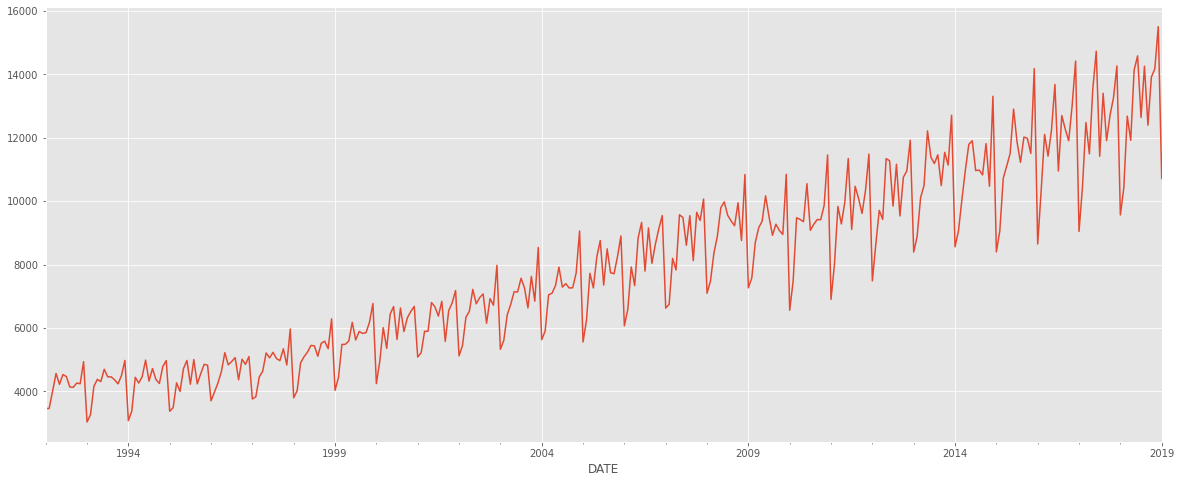

In [4]:
df.Sales.plot();

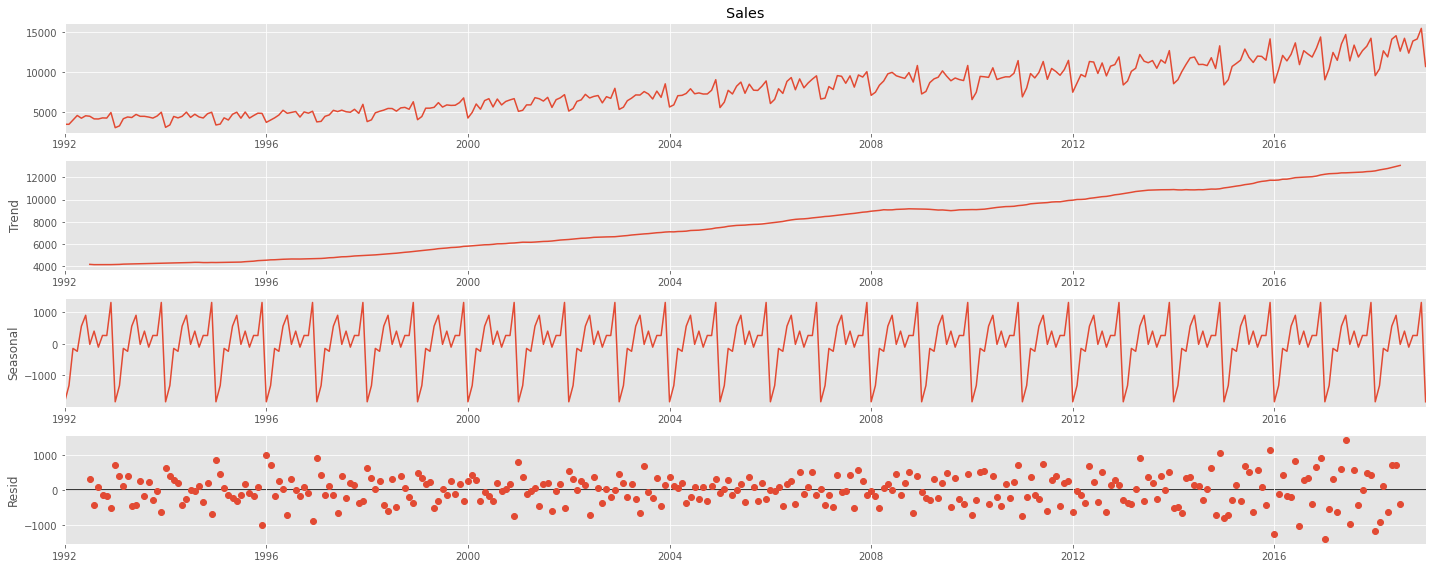

In [5]:
seasonal_decompose(df['Sales']).plot();

In [6]:
train=df.iloc[:313]
test=df.iloc[313:]

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler.fit(train)

scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [8]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [10]:
n_input=12
n_features=1

generator=TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [11]:
model=Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit_generator(generator, epochs=50)

Epoch 1/50
301/301 [==============================] - 16s 41ms/step - loss: 0.0187
Epoch 2/50
301/301 [==============================] - 6s 20ms/step - loss: 0.0107
Epoch 3/50
301/301 [==============================] - 7s 24ms/step - loss: 0.0080
Epoch 4/50
301/301 [==============================] - 6s 20ms/step - loss: 0.0074
Epoch 5/50
301/301 [==============================] - 6s 20ms/step - loss: 0.0073
Epoch 6/50
301/301 [==============================] - 6s 20ms/step - loss: 0.0059
Epoch 7/50
301/301 [==============================] - 6s 19ms/step - loss: 0.0040
Epoch 8/50
301/301 [==============================] - 6s 20ms/step - loss: 0.0033
Epoch 9/50
301/301 [==============================] - 6s 20ms/step - loss: 0.0032
Epoch 10/50
301/301 [==============================] - 6s 20ms/step - loss: 0.0027
Epoch 11/50
301/301 [==============================] - 6s 20ms/step - loss: 0.0022
Epoch 12/50
301/301 [==============================] - 8s 26ms/step - loss: 0.0020
Epoch 13/50


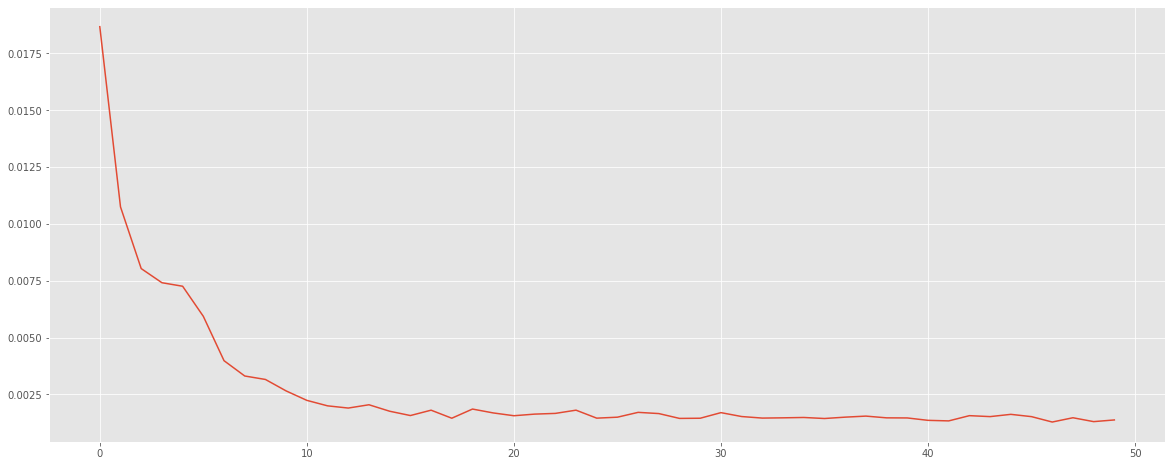

In [14]:
myloss=model.history.history['loss']
plt.plot(range(len(myloss)), myloss);

In [15]:
# 12 history steps ----> step 13
# Last 12 points train ----> pt 1 of test data

In [16]:
first_eval_batch=scaled_train[-12:]
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [17]:
first_eval_batch.reshape((1,
                          n_input, 
                          n_features))

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [18]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 180ms/step


array([[0.19231288],
       [0.21456283],
       [0.20376098],
       [0.22628742],
       [0.23986761],
       [0.20291969],
       [0.22468567],
       [0.20842496],
       [0.21705922],
       [0.22311413],
       [0.23447382],
       [0.18288372]], dtype=float32)

In [19]:
# Forecast using RNN model

In [38]:
# holding my predictions
test_predictions=[]

# last n_input from training set
first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input, n_features))

In [ ]:
for i in range(len(test)):
  # one timestamp ahead of historical 12 points
  current_pred = model.predict(current_batch)[0]

  # store that prediction
  test_predictions.append(current_pred)

  # update current batch to include prediction
  current_batch=np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [34]:
test_predictions

[array([0.68155515], dtype=float32),
 array([0.7952689], dtype=float32),
 array([0.752843], dtype=float32),
 array([0.90538037], dtype=float32),
 array([0.99708617], dtype=float32),
 array([0.73209286], dtype=float32),
 array([0.8945521], dtype=float32),
 array([0.7538761], dtype=float32),
 array([0.84373605], dtype=float32),
 array([0.867362], dtype=float32),
 array([0.96313775], dtype=float32),
 array([0.57723844], dtype=float32)]

In [35]:
true_predictions=scaler.inverse_transform(test_predictions)

In [36]:
test['Predictions']=true_predictions

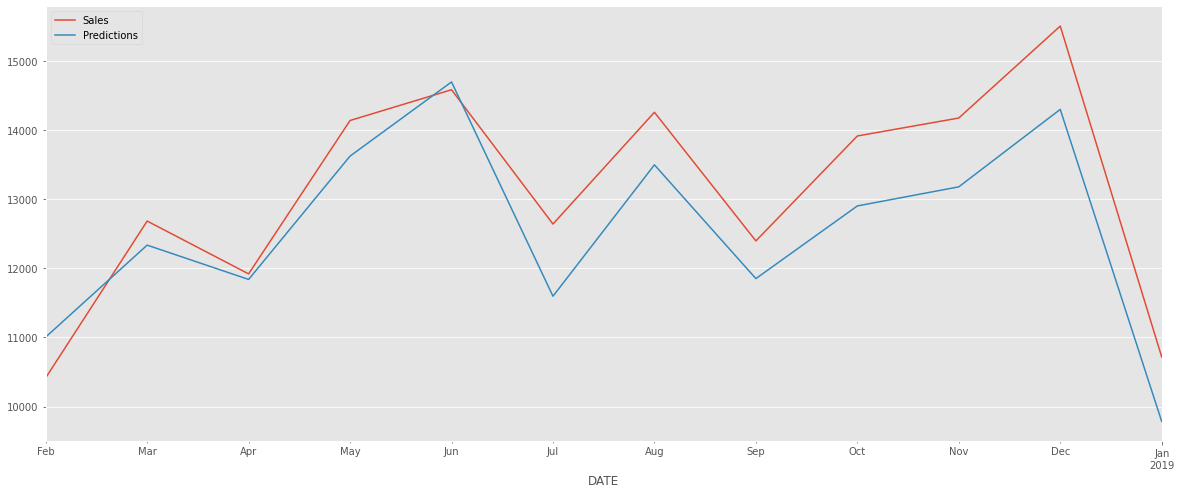

In [37]:
test.plot();